In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Cerebellum import *

In [22]:
## PREPARE THE EXPERIMENTAL VARIABLES (SIGNALS AND AGENT).
def ExpSetup(time, dt, delay=.4):
    
    time = time         # The total time of a single trial. (All times in seconds).
    dt = dt             # Each iteration of the simulation corresponds to 0.01 seconds.
    
    x_f_delay = delay
    # CUE (first PREDICTIVE SIGNAL OF THE DISTURBANCE).
    x_mag = 1.           # The intensity of the cue signal (in arbitrary units).
    x_time = 0.4         # Amount of time that the cue will be present.
    x_start = 0.5        # When the cue signal starts (note that it starts 0.5 seconds before the disturbance).

    # The cue signal (x) is modeled as a simple rectangular function.
    x = np.array([np.concatenate([np.zeros((int(x_start/dt),1)),
                        np.ones((int(x_time/dt),1))*x_mag,
                        np.zeros((int(time/dt-(x_start+x_time)/dt),1))], axis=0)])
    X = np.array([np.tile(x, (1,1,1))])

    
    # FORCE (DISTURBANCE).
    f_mag = 600.         # Magnitude of the disturbance (in Newtons).
    f_time = 0.3         # Amount of time that the disturbance will be applied.
    f_start = np.around(x_start + x_f_delay, decimals=2)
    
    # The disturbance (f) is modeled as a rectangular function (simple pulse).
    f = np.concatenate([np.zeros(int(f_start/dt)),
                        np.ones(int(f_time/dt))*f_mag,
                        np.zeros(int(time/dt-(f_start+f_time)/dt))])
    
    agent = CerebellarAgent(mass=67., height=0.85, dt=dt, pd_gains=[1250., 250.], feedback_delay=0.1, 
                            nInputs=1, nOutputs=1, nPCpop=10, nIndvBasis=50, nSharedBasis=200, beta_MF=1e-3, 
                            beta_PF=1e-4, range_delays=[0.05, 0.5], range_TC=[0.05, 2.], range_scaling=[1, 100], 
                            range_W=[0., 1.], parallel_channels=True)
    
    return agent, X, f, f_start

In [23]:
time_trial = 8.         
dt = 0.01  

agent, X, f, f_start = ExpSetup(time=time_trial, dt=dt, delay=.4)  

#agent.ff.test_basis(X, save=False)

## Standard training CS-US acquisition

In [4]:
# Simulation.
agent.reset()

n_trials = 300

log_acq = []
for tr in range(n_trials):
    for t in np.arange(0, int(time_trial/dt)):
        th, u_ff = agent.step(X[:,:,t], f[t], update=True)
        log_acq.append(np.array([th, u_ff], dtype=object))

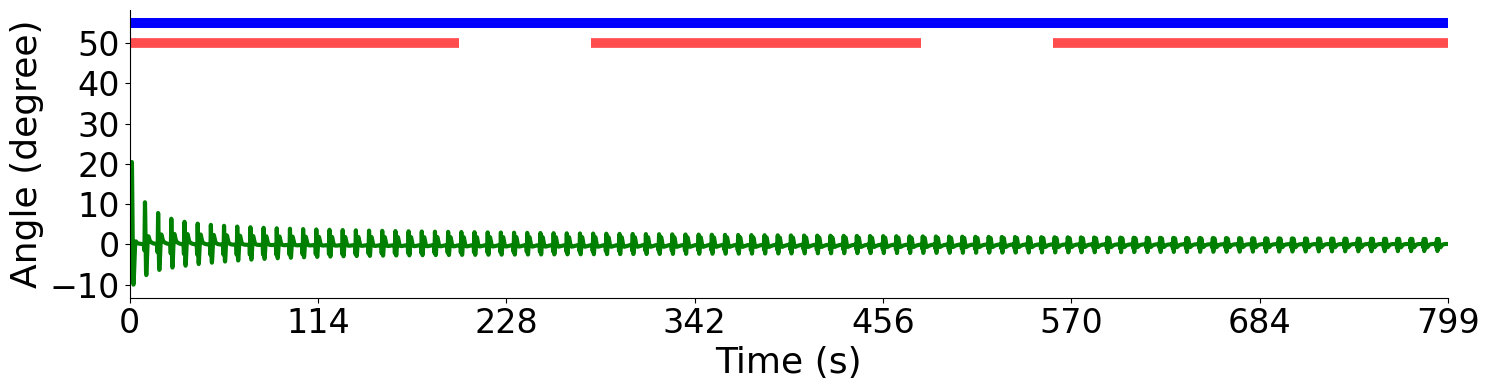

In [26]:
# Plot.
plt.figure(figsize=(15,4))

#plt.title('Behavior during acquisition', fontsize=28)
'''
start = np.array([0,25,35,60,70]) * (time_trial/dt)
end = np.array([25,35,60,70,99]) * (time_trial/dt)
plt.hlines(y=[50]*5, xmin=start, xmax=end, color='r', linewidth=7, alpha=0.8, linestyles=('solid','dotted','solid','dotted','solid'))
'''

start = np.array([0,35,70]) * (time_trial/dt)
end = np.array([25,60,100]) * (time_trial/dt)
plt.hlines(y=np.repeat(50,3), xmin=start, xmax=end, color='r', linewidth=7, alpha=0.7, linestyles=('solid','solid','solid'))

plt.hlines(y=np.repeat(55,5), xmin=0, xmax=100*(time_trial/dt), color='b', linewidth=7, alpha=0.7, linestyles='solid')


plt.plot(np.array(log_acq)[:int(n_trials*time_trial/dt),0], c='g', linewidth=3.)
#for t in np.linspace(0, n_trials*time_trial, n_trials+1):
    #plt.axvline(x=((t+f_start)/dt)-1, color='black', linestyle='--', linewidth=1.)
plt.xlabel('Time (s)', fontsize=26)
plt.ylabel('Angle (degree)', fontsize=26)
plt.xticks(np.linspace(1,int(n_trials*time_trial/dt),8, dtype=np.int_)-1, np.linspace(1,int(n_trials*time_trial),8, dtype=np.int_)-1, fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0, int(n_trials*time_trial/dt))
plt.tight_layout()
sns.despine()
#plt.savefig('acq1.png', dpi=600)
plt.show()

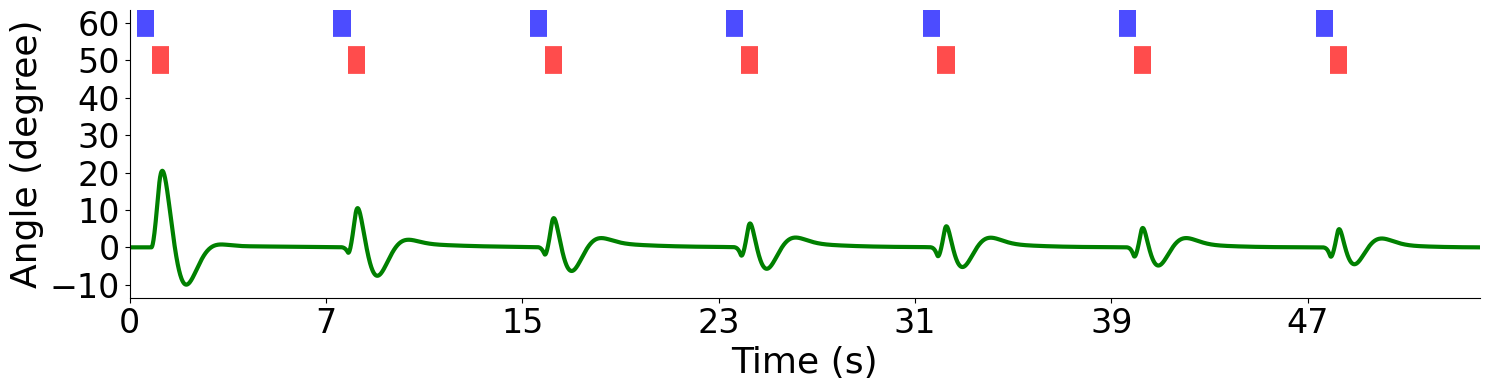

In [27]:
# Plot.
plt.figure(figsize=(15,4))

nn=7


start = np.arange(nn) * (time_trial/dt) + (f_start/dt)
end = start + (0.7/dt)
plt.hlines(y=[50]*nn, xmin=start, xmax=end, color='r', linewidth=20, alpha=.7, linestyles=('solid','solid','solid','solid','solid'))

start = np.arange(nn) * (time_trial/dt) + (0.3/dt)
end = start + (0.7/dt)
plt.hlines(y=[60]*nn, xmin=start, xmax=end, color='b', linewidth=20, alpha=.7, linestyles=('solid','solid','solid','solid','solid'))


#plt.title('Behavior during acquisition', fontsize=28)
plt.plot(np.array(log_acq)[:int(nn*time_trial/dt),0], c='g', linewidth=3.)
#for t in np.linspace(0, nn*time_trial, 7+1):
    #plt.axvline(x=((t)/dt), color='black', linestyle='--', linewidth=2.)
plt.xlabel('Time (s)', fontsize=26)
plt.ylabel('Angle (degree)', fontsize=26)
plt.xticks(np.linspace(1,int(nn*time_trial/dt),nn+1, dtype=np.int_)-1, np.linspace(1,int(nn*time_trial),nn+1, dtype=np.int_)-1, fontsize=24)
plt.yticks(fontsize=24)
plt.xlim(0,5500)
plt.tight_layout()
sns.despine()
#plt.savefig('acq2.png', dpi=600)
plt.show()

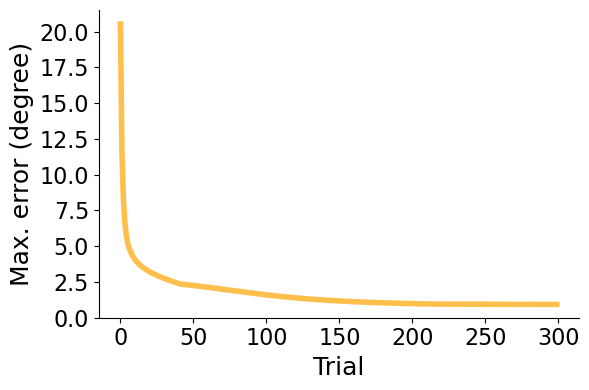

In [5]:
plt.figure(figsize=(6,4))

max_err_trials = np.max(np.abs(np.array(log_acq)[:,0].reshape((n_trials, int(time_trial/dt)))), axis=1)
plt.plot( max_err_trials, color='orange', alpha=.7, linewidth=4 )
plt.xlabel('Trial', fontsize=18)
plt.ylabel('Max. error (degree)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0)
plt.tight_layout()
sns.despine()
#plt.savefig('error_curve.png', dpi=600)
plt.show()

In [28]:
#agent.ff.test_basis(X, reset=False, save=False)

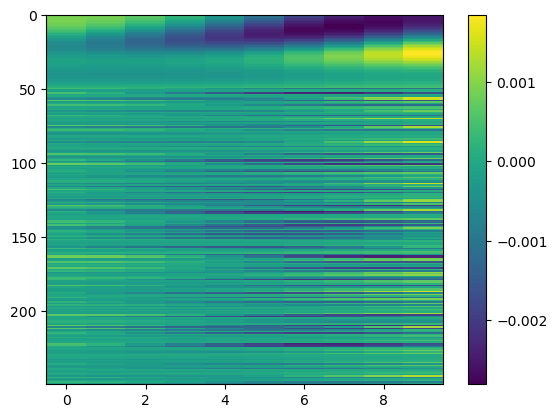

In [16]:
plt.imshow(agent.ff.w_PF, aspect='auto', interpolation='none')
plt.colorbar()

## Performance across delays

In [100]:
time_trial = 8.         
dt = 0.01  

In [101]:
delays = np.arange(.1, 1, .1)
log_acq_delays = []
for d in delays:
    agent, X, f, f_start = ExpSetup(time=time_trial, dt=dt, delay=d)  
    log_acq = []
    for tr in range(n_trials):
        for t in np.arange(0, int(time_trial/dt)):
            th, u_ff = agent.step(X[:,:,t], f[t], update=True)
            log_acq.append(np.array([th, u_ff], dtype=object))
    log_acq_delays.append(log_acq)

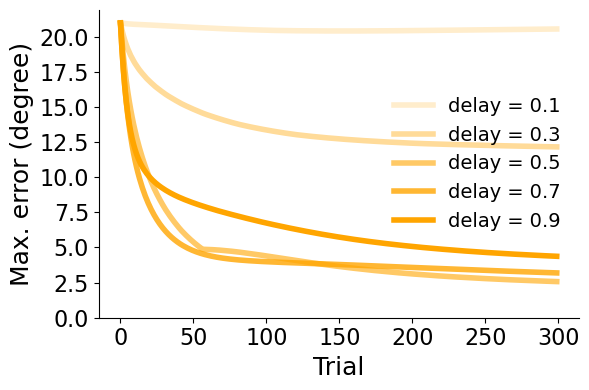

In [102]:
plt.figure(figsize=(6,4))

for i, d in enumerate(delays):
    log_acq = log_acq_delays[i]
    max_err_trials = np.max(np.abs(np.array(log_acq)[:,0].reshape((n_trials, int(time_trial/dt)))), axis=1)
    if i%2==0:
        plt.plot( max_err_trials, color='orange', alpha=d+.1, linewidth=4, label='delay = '+str(np.round(d,1)) )

plt.xlabel('Trial', fontsize=18)
plt.ylabel('Max. error (degree)', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0)
plt.legend(frameon=False, fontsize=14)
plt.tight_layout()
sns.despine()
plt.savefig('delay_performance_fixedDelayModel_5e-1.png', dpi=600)
plt.show()

## Catch trials

In [ ]:
'''
# Simulation.
agent.reset()

n_trials = 100

log_acq = []
for tr in range(n_trials):
    new_f = np.copy(f)
    if (tr >= 25 and tr < 35) or (tr >= 60 and tr < 70):
        new_f = f*0
    for t in np.arange(0, int(time_trial/dt)):
        th, u_ff = agent.step(X[:,:,t], new_f[t], update=True)
        log_acq.append(np.array([th, u_ff]))
'''